In [1]:
import sys, os, shutil, math
import numpy as np
from obspy import *
from obspy.signal.rotate import rotate2zne
import argparse
import matplotlib
#matplotlib.use("Qt5Agg")
from matplotlib import mlab
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.animation as animation
from itertools import product, combinations
from numpy import sin, cos
import subprocess

In [3]:
def rotate_xyz(cube, theta_x, theta_y, theta_z, disp_x, disp_y, disp_z):
#############################################
# this method take initial coordinates of a cube
# and applies a rotation around (theta_x, theta_y, theta_z)
# as well as a displacement (disp_x, disp_y, disp_z)
# ----------------------------------------------------------
# cube stores each edge-line in the format [(s_x, e_x),(s_y, e_y),(s_z, e_z), ...] 
# s, e are start-, end-points (in e.g. (s_x, s_y, s_z)-coordinates) of each edge line
#############################################
    rot_cube = []
    for i in range(len(cube)):
        s = [cube[i][0][0], cube[i][1][0], cube[i][2][0]]
        e = [cube[i][0][1], cube[i][1][1], cube[i][2][1]]
# rotate around z-axis
        s_z = [s[0] * cos(theta_z) - s[1] * sin(theta_z), 
                   s[0] * sin(theta_z) + s[1] * cos(theta_z),
                   s[2]]
        e_z = [e[0] * cos(theta_z) - e[1] * sin(theta_z), 
                   e[0] * sin(theta_z) + e[1] * cos(theta_z),
                   e[2]]
# rotate around y-axis     
        s_zy = [s_z[0] * cos(theta_y) - s_z[2] * sin(theta_y),
                    s_z[1], 
                    s_z[0] * sin(theta_y) + s_z[2] * cos(theta_y)]
        e_zy = [e_z[0] * cos(theta_y) - e_z[2] * sin(theta_y),
                    e_z[1], 
                    e_z[0] * sin(theta_y) + e_z[2] * cos(theta_y)]
# rotate around x-axis and add displacement      
        s_zyx = [s_zy[0] + disp_x,
                     s_zy[2] * cos(theta_x) - s_zy[1] * sin(theta_x) + disp_y, 
                     s_zy[2] * sin(theta_x) + s_zy[1] * cos(theta_x) + disp_z]
        e_zyx = [e_zy[0] + disp_x,
                     e_zy[2] * cos(theta_x) - e_zy[1] * sin(theta_x) + disp_y, 
                     e_zy[2] * sin(theta_x) + e_zy[1] * cos(theta_x) + disp_z]
                
        rot_cube.append(list(zip(s_zyx, e_zyx)))
    return rot_cube

    

def plotframe(data, u_lim, l_lim):
########################################
# this method plots one single frame of
# the video, that is, a cube moved and
# rotated by a certain displacement
# and rotation angle, stored in data
########################################
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    c1 = (1, 0, 0)
    c2 = (0, 1, 0)
    c3 = (0, 0, 1)    

    w = 0.5

# here you can choose which line you want to show in which style:
    lineOn = [1, 2, 5, 6, 7, 8, 9, 10, 11]
    linestyles = ['--',  '-',  '-', '--', '--',  '-',  '-',  '-',  '-',  '-',  '-',  '-']
    linewidths = [   w,    w,    w,    w,    w,    w,    w,    w,    w,    w,    w,    w]

# plot the cube
    for i in range(len(data)):
        vert = []
        j = 0
# first we plot the edge-lines
        for c in data[i]:
            if j in lineOn:
                ax.plot3D(*c, color="k", linestyle=linestyles[j], linewidth=linewidths[j])
            v = list(zip(*c))
            vert.append(v)
            j += 1
# make the faces you want to show, each consisting of
# four points (x,y,z)
        face1 = [vert[1][0], vert[1][1], vert[9][1], vert[9][0]] 
        face2 = [vert[5][0], vert[5][1], vert[11][1], vert[11][0]] 
        face3 = [vert[8][0], vert[8][1], vert[11][1], vert[11][0]] 
        f1 = Poly3DCollection([face1])
        f2 = Poly3DCollection([face2])
        f3 = Poly3DCollection([face3])
# paint the faces
        f1.set_color(c1)
        f2.set_color(c2)
        f3.set_color(c3)
# add the faces to the plot
        ax.add_collection3d(f1)
        ax.add_collection3d(f2)
        ax.add_collection3d(f3)

# do some fine tunig of the plot
        ax.set_xlim3d([l_lim, u_lim])
        ax.set_xlabel('X')
        ax.set_xticklabels([])

        ax.set_ylim3d([l_lim, u_lim])
        ax.set_ylabel('Y')
        ax.set_yticklabels([])

        ax.set_zlim3d([l_lim, u_lim])
        ax.set_zlabel('Z')
        ax.set_zticklabels([])


#        ax.view_init(0, 0) # Y-Z plane
#        ax.view_init(0, 90) # X-Z plane
#        ax.view_init(90, 0) # X-Y plane

        #ax.set_title('')
        print('frame: ', i, ' / ', len(data))
        plt.savefig('C:\\Users\\Sabrina Keil\\Documents\\PhD\\Meetings\\Defense\\plots\\'+str(i).zfill(5)+'.png')
        ax.clear()


def rotate_xyz_old(cube, theta_x, theta_y, theta_z, disp_x, disp_y, disp_z):
    rot_cube = []
    for i in range(len(cube)):
        s = [cube[i][0][0], cube[i][1][0], cube[i][2][0]]
        e = [cube[i][0][1], cube[i][1][1], cube[i][2][1]]
        s_z = [s[0] * cos(theta_z) - s[1] * sin(theta_z), 
                   s[0] * sin(theta_z) + s[1] * cos(theta_z),
                   s[2]]
        e_z = [e[0] * cos(theta_z) - e[1] * sin(theta_z), 
                   e[0] * sin(theta_z) + e[1] * cos(theta_z),
                   e[2]]      
        s_zy = [s_z[0] * cos(theta_y) - s_z[2] * sin(theta_y),
                    s_z[1], 
                    s_z[0] * sin(theta_y) + s_z[2] * cos(theta_y)]
        e_zy = [e_z[0] * cos(theta_y) - e_z[2] * sin(theta_y),
                    e_z[1], 
                    e_z[0] * sin(theta_y) + e_z[2] * cos(theta_y)]      
        s_zyx = [s_zy[0] + disp_x,
                     s_zy[2] * cos(theta_x) - s_zy[1] * sin(theta_x) + disp_y, 
                     s_zy[2] * sin(theta_x) + s_zy[1] * cos(theta_x) + disp_z]
        e_zyx = [e_zy[0] + disp_x,
                     e_zy[2] * cos(theta_x) - e_zy[1] * sin(theta_x) + disp_y, 
                     e_zy[2] * sin(theta_x) + e_zy[1] * cos(theta_x) + disp_z]
                
        rot_cube.append(zip(s_zyx, e_zyx))
    return rot_cube

    

def plotframe_old(data, u_lim, l_lim):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    c1 = (1, 0, 0)
    c2 = (0, 1, 0)
    c3 = (0, 0, 1)    

    w = 0.5

    lineOn = [1, 2, 5, 6, 7, 8, 9, 10, 11]
    linestyles = ['--',  '-',  '-', '--', '--',  '-',  '-',  '-',  '-',  '-',  '-',  '-']
    linewidths = [   w,    w,    w,    w,    w,    w,    w,    w,    w,    w,    w,    w]

    for i in range(len(data)):
        vert = []
        j = 0
        for c in data[i]:
            if j in lineOn:
                ax.plot3D(*c, color="k", linestyle=linestyles[j], linewidth=linewidths[j])
            j += 1
            v = zip(*c)
            #print v
            vert.append(v)
        face1 = [vert[1][0], vert[1][1], vert[9][1], vert[9][0]] 
        face2 = [vert[5][0], vert[5][1], vert[11][1], vert[11][0]] 
        face3 = [vert[8][0], vert[8][1], vert[11][1], vert[11][0]] 
        f1 = Poly3DCollection([face1])
        f2 = Poly3DCollection([face2])
        f3 = Poly3DCollection([face3])
        f1.set_color(c1)
        f2.set_color(c2)
        f3.set_color(c3)
        ax.add_collection3d(f1)
        ax.add_collection3d(f2)
        ax.add_collection3d(f3)
        
        ax.set_xlim3d([l_lim, u_lim])
        ax.set_xlabel('X')

        ax.set_ylim3d([l_lim, u_lim])
        ax.set_ylabel('Y')

        ax.set_zlim3d([l_lim, u_lim])
        ax.set_zlabel('Z')

#        ax.view_init(0, 0) # Y-Z plane
#        ax.view_init(0, 90) # X-Z plane
#        ax.view_init(90, 0) # X-Y plane

        ax.set_title('translation only')
        print('frame: ', i, ' / ', len(data))
        plt.savefig('C:\\Users\\Sabrina Keil\\Documents\\PhD\\Meetings\\Defense\\plots\\'+str(i).zfill(5)+'.png')
        ax.clear()



In [4]:
def main():

    #parser = argparse.ArgumentParser(description='calculate stacked amplitude spectra for a specified station', prog='stack_spectrum.py')
    #
    #parser.add_argument('-S', metavar='station code', type=str, nargs=2,
    #                    default='', dest='sta', help='2 station codes of stations to be analized, ROT and ACC')
    #parser.add_argument('-f', metavar='frequency band', type=float, nargs=2,
    #                    default=[1,2], dest='f', help='[float, float] freq_min, freq_max')
    #parser.add_argument('-T', metavar='start time', type=str,
    #                    default='', dest='start', help='Time to start from (YYYY-MM-DDThh:mm:ss)')
    #parser.add_argument('-E', metavar='end time', type=str,
    #                    default='', dest='end', help='Time to start from (YYYY-MM-DDThh:mm:ss)')
    
    #args = parser.parse_args()
    
    #if args.sta == '':
    #    print('ERROR: No station code given!')
    #    sys.exit(1)

    cl = Client_fdsn("IRIS", debug=True)        
    #path = '/bay_mobil/Koeln/data/'
    start = UTCDateTime('2018-07-14T05:07:57')
    end = start + 23

    net = 'HV'
    sta = ['UWE', 'UWE']
    loc = '*'
    f = [0.01, 1.5]

    p = 0.1    

    pre_filt = (0.005, 0.006, 20.0, 25.0)

    #inv = read_inventory('/bay_mobil/Koeln/inventory/station.xml')

    dec_fact = 10


    #set scaling factors!!
    #scale_disp = 1.e4
    scale_disp = 0.0
    scale_disp_lim = 1.e4
    scale_rot = 0.66e3
    #scale_rot = 0.0

    l = 300

    disp, rot = get_data(cl, net, sta, loc, start, end, f, p, pre_filt, dec_fact)

    _rot = np.copy(np.asarray(rot))
    _disp = np.copy(np.asarray(disp)*scale_disp_lim)
    rot = np.asarray(rot) * scale_rot
    disp = np.asarray(disp) * scale_disp

    print(_disp)
    print(disp)

    u_lim = max(_disp.flatten())+l
    l_lim = min(_disp.flatten())-l

    print(u_lim)
    print(l_lim)

    cube = []
    d = [-1*l, l]
    for s, e in combinations(np.array(list(product(d,d,d))), 2):
        if np.sum(np.abs(s-e)) == d[1]-d[0]:
            cube.append(list(zip(s, e)))

    print(cube)



    data = []
    for i in range(len(rot[0])):
        d = rotate_xyz(cube, rot[0][i], rot[1][i], rot[2][i], disp[0][i], disp[1][i], disp[2][i])
        data.append(d)


    if not os.path.exists('frames/temp/'):
        os.makedirs('frames/temp/')

    plotframe(data, u_lim, l_lim)

    #subprocess.call('avconv -f image2 -i frames/temp/frame%05d.png -r 20 -s 800x800 animation/animationCologne_'+args.sta[0]+'_'+args.sta[1]+'_'+args.start+'_'+args.end+'.avi', shell=True)

    subprocess.call('ffmpeg -f image2 -i frames/temp/frame%05d.png -r 20 -s 800x800 animationHawaii_'+sta[0]+'_'+sta[1]+'_'+str(scale_rot)+'_'+str(scale_disp)+'.swf', shell=True)
    #shutil.rmtree('frames/temp/')


In [32]:
#data
import matplotlib.pyplot as plt
import numpy as np
from obspy.core import Trace, Stream
from scipy.signal import hilbert, convolve

from twistpy.convenience import ricker
from twistpy.polarization import (
    TimeDomainAnalysis6C,
    TimeFrequencyAnalysis6C,
    PolarizationModel6C,
    SupportVectorMachine,
    EstimatorConfiguration,
)
from twistpy.utils import stransform

rng = np.random.default_rng(1)

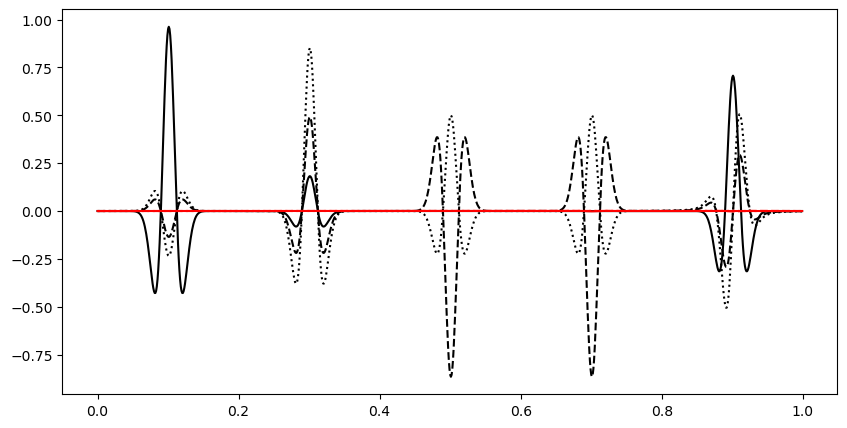

In [205]:
# Generate an empty time series for each wave
N = 1000  # Number of samples in the time series
signal1 = np.zeros((N, 6))  # Each signal has six components
signal2 = np.zeros((N, 6))
signal3 = np.zeros((N, 6))
signal4 = np.zeros((N, 6))
signal5 = np.zeros((N, 6))

dt = 1.0 / 1000.0  # sampling interval
t = np.arange(0, signal1.shape[0]) * dt  # time axis
wavelet, t_wav, wcenter = ricker(
    t, 20.0
)  # generate a Ricker wavelet with 30 Hz center frequency
wavelet = wavelet[wcenter - int(len(t) / 2) : wcenter + int(len(t) / 2)]
wavelet_hilb = np.imag(
    hilbert(wavelet)
)  # Here we make use of the Hilbert transform to generate a Ricker wavelet
# with a 90 degree phase shift. This is to account for the fact that, for Rayleigh waves, the horizontal components are
# phase-shifted by 90 degrees with respect to the other components.

wave1 = PolarizationModel6C(
    wave_type="P", theta=20, phi=30, vp=1000, vs=400
)  # Generate a P-wave polarization model for
# a P-wave recorded at the free surface with an inclination of 20 degrees, an azimuth of 30 degrees. The local P- and
# S-wave velocities are 1000 m/s and 400 m/s
wave2 = PolarizationModel6C(
    wave_type="SV", theta=20, phi=30, vp=1000, vs=400
)  # Generate an SV-wave polarization model
wave3 = PolarizationModel6C(
    wave_type="SH", theta=20, phi=30, vs=400, vl=400
)  # Generate an SH-wave polarization model
wave4 = PolarizationModel6C(
    wave_type="L", phi=30, vl=300
)  # Generate a Love-wave polarization model
wave5 = PolarizationModel6C(
    wave_type="R", phi=30, vr=300, xi=-45
)  # Generate a Rayleigh-wave polarization model with a
# Rayleigh wave ellipticity angle of -45 degrees.

signal1[100, :] = wave1.polarization.real.T
signal2[300, :] = wave2.polarization.real.T
signal3[500, :] = wave3.polarization.real.T
signal4[700, :] = wave4.polarization.real.T
signal5[900, 2:] = np.real(wave5.polarization[2:].T)
signal5[900, 0:2] = np.imag(wave5.polarization[0:2].T)

for j in range(0, signal1.shape[1]):
    signal1[:, j] = convolve(signal1[:, j], wavelet, mode="same")
    signal2[:, j] = convolve(signal2[:, j], wavelet, mode="same")
    signal3[:, j] = convolve(signal3[:, j], wavelet, mode="same")
    signal4[:, j] = convolve(signal4[:, j], wavelet, mode="same")
    if (
        j == 0 or j == 1
    ):  # Special case for horizontal translational components of the Rayleigh wave
        signal5[:, j] = convolve(signal5[:, j], wavelet_hilb, mode="same")
    else:
        signal5[:, j] = convolve(signal5[:, j], wavelet, mode="same")

signal = signal1 + signal2 + signal3 + signal4 + signal5  # sum all signals together

plt.figure(figsize=(10, 5))
plt.plot(t, signal[:, 0], "k:", label="traN")
plt.plot(t, signal[:, 1], "k--", label="traE")
plt.plot(t, signal[:, 2], "k", label="traZ")
plt.plot(t, signal[:, 3], "r:", label="rotN")
plt.plot(t, signal[:, 4], "r--", label="rotE")
plt.plot(t, signal[:, 5], "r", label="rotZ")
plt.show()

In [206]:
disp = (signal[:,0],signal[:,1],signal[:,2])
rot =  (signal[:,3],signal[:,4],signal[:,5])

In [207]:
x=np.linspace(0,100,len(disp[0]))

In [208]:
print(np.shape(x))
print(x[0])
print(disp[0])

(1000,)
0.0
[ 6.04362654e-17  1.30967887e-16  2.81522256e-16  6.00260074e-16
  1.26953017e-15  2.66330809e-15  5.54207641e-15  1.14391607e-14
  2.34198508e-14  4.75598065e-14  9.57987033e-14  1.91399278e-13
  3.79297084e-13  7.45546253e-13  1.45352598e-12  2.81074383e-12
  5.39097133e-12  1.02555034e-11  1.93503111e-11  3.62123411e-11
  6.72139589e-11  1.23735119e-10  2.25919319e-10  4.09106853e-10
  7.34749113e-10  1.30874817e-09  2.31197639e-09  4.05057224e-09
  7.03801580e-09  1.21277415e-08  2.07252703e-08  3.51241277e-08
  5.90323663e-08  9.83893502e-08  1.62619605e-07  2.66537280e-07
  4.33207799e-07  6.98200977e-07  1.11584215e-06  1.76829624e-06
  2.77861652e-06  4.32926754e-06  6.68810106e-06  1.02443316e-05
  1.55577227e-05  2.34249441e-05  3.49678602e-05  5.17493088e-05
  7.59226306e-05  1.10421695e-04  1.59198254e-04  2.27512918e-04
  3.22284651e-04  4.52501026e-04  6.29687389e-04  8.68427086e-04
  1.18691683e-03  1.60753107e-03  2.15735658e-03  2.86864450e-03
  3.77911104e

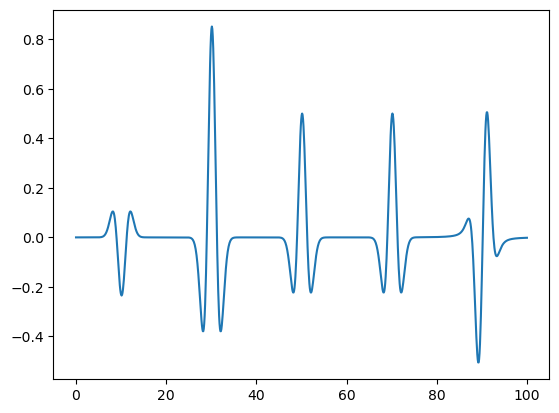

In [209]:
plt.plot(x,disp[0])
plt.show()

In [210]:
#set scaling factors!!
scale_disp = 400
#scale_disp = 0.0
scale_disp_lim = 1000 #1e4 verändert cube größe
#scale_rot = 0.66e3
scale_rot =400 #100000

l = 300

_rot = np.copy(np.asarray(rot))
_disp = np.copy(np.asarray(disp)*scale_disp_lim)
rot = np.asarray(rot) * scale_rot
disp = np.asarray(disp) * scale_disp

print(_disp)
print(disp)


[[ 6.04362654e-14  1.30967887e-13  2.81522256e-13 ... -1.71863155e+00
  -1.66275209e+00 -1.60930622e+00]
 [ 3.48928941e-14  7.56143447e-14  1.62536950e-13 ... -9.92252385e-01
  -9.59990367e-01 -9.29133381e-01]
 [-2.47832966e-13 -5.37064288e-13 -1.15444750e-12 ... -8.02297916e-12
  -3.82434691e-12 -1.80823018e-12]]
[[ 2.41745062e-14  5.23871547e-14  1.12608902e-13 ... -6.87452618e-01
  -6.65100836e-01 -6.43722489e-01]
 [ 1.39571576e-14  3.02457379e-14  6.50147801e-14 ... -3.96900954e-01
  -3.83996147e-01 -3.71653352e-01]
 [-9.91331864e-14 -2.14825715e-13 -4.61779001e-13 ... -3.20919166e-12
  -1.52973877e-12 -7.23292072e-13]]


In [211]:
print(max(disp.flatten()))
print(max(_disp.flatten()))

print(max(rot.flatten()))

385.0268234942304
962.567058735576
0.4714032113394855


In [212]:
#u_lim = max(_disp.flatten())+l
#l_lim = min(_disp.flatten())-l

u_lim=900
l_lim=-900

print(u_lim)
print(l_lim)

cube = []
d = [-1*l, l]
for s, e in combinations(np.array(list(product(d,d,d))), 2):
    if np.sum(np.abs(s-e)) == d[1]-d[0]:
        cube.append(list(zip(s, e)))

#print(cube)

900
-900
[[(-300, -300), (-300, -300), (-300, 300)], [(-300, -300), (-300, 300), (-300, -300)], [(-300, 300), (-300, -300), (-300, -300)], [(-300, -300), (-300, 300), (300, 300)], [(-300, 300), (-300, -300), (300, 300)], [(-300, -300), (300, 300), (-300, 300)], [(-300, 300), (300, 300), (-300, -300)], [(-300, 300), (300, 300), (300, 300)], [(300, 300), (-300, -300), (-300, 300)], [(300, 300), (-300, 300), (-300, -300)], [(300, 300), (-300, 300), (300, 300)], [(300, 300), (300, 300), (-300, 300)]]


In [213]:
data = []
for i in range(len(rot[0])):
    d = rotate_xyz(cube, rot[0][i], rot[1][i], rot[2][i], disp[0][i], disp[1][i], disp[2][i])
    data.append(d)


#if not os.path.exists('frames/temp/'):
#    os.makedirs('frames/temp/')
#print(data)

[[[(-300.0, -300.0), (-300.0, 300.0), (-300.0000000000001, -300.0000000000001)], [(-300.0, -300.0), (-300.0, -300.0), (-300.0000000000001, 299.9999999999999)], [(-300.0, 300.0), (-300.0, -300.0), (-300.0000000000001, -300.0000000000001)], [(-300.0, -300.0), (300.0, 300.0), (-300.0000000000001, 299.9999999999999)], [(-300.0, 300.0), (300.0, 300.0), (-300.0000000000001, -300.0000000000001)], [(-300.0, -300.0), (-300.0, 300.0), (299.9999999999999, 299.9999999999999)], [(-300.0, 300.0), (-300.0, -300.0), (299.9999999999999, 299.9999999999999)], [(-300.0, 300.0), (300.0, 300.0), (299.9999999999999, 299.9999999999999)], [(300.0, 300.0), (-300.0, 300.0), (-300.0000000000001, -300.0000000000001)], [(300.0, 300.0), (-300.0, -300.0), (-300.0000000000001, 299.9999999999999)], [(300.0, 300.0), (300.0, 300.0), (-300.0000000000001, 299.9999999999999)], [(300.0, 300.0), (-300.0, 300.0), (299.9999999999999, 299.9999999999999)]], [[(-299.99999999999994, -299.99999999999994), (-299.99999999999994, 300.0

In [214]:
print(np.shape(data))

(1000, 12, 3, 2)


frame:  0  /  1000
frame:  1  /  1000
frame:  2  /  1000
frame:  3  /  1000
frame:  4  /  1000
frame:  5  /  1000
frame:  6  /  1000
frame:  7  /  1000
frame:  8  /  1000
frame:  9  /  1000
frame:  10  /  1000
frame:  11  /  1000
frame:  12  /  1000
frame:  13  /  1000
frame:  14  /  1000
frame:  15  /  1000
frame:  16  /  1000
frame:  17  /  1000
frame:  18  /  1000
frame:  19  /  1000
frame:  20  /  1000
frame:  21  /  1000
frame:  22  /  1000
frame:  23  /  1000
frame:  24  /  1000
frame:  25  /  1000
frame:  26  /  1000
frame:  27  /  1000
frame:  28  /  1000
frame:  29  /  1000
frame:  30  /  1000
frame:  31  /  1000
frame:  32  /  1000
frame:  33  /  1000
frame:  34  /  1000
frame:  35  /  1000
frame:  36  /  1000
frame:  37  /  1000
frame:  38  /  1000
frame:  39  /  1000
frame:  40  /  1000
frame:  41  /  1000
frame:  42  /  1000
frame:  43  /  1000
frame:  44  /  1000
frame:  45  /  1000
frame:  46  /  1000
frame:  47  /  1000
frame:  48  /  1000
frame:  49  /  1000
frame:  50

frame:  396  /  1000
frame:  397  /  1000
frame:  398  /  1000
frame:  399  /  1000
frame:  400  /  1000
frame:  401  /  1000
frame:  402  /  1000
frame:  403  /  1000
frame:  404  /  1000
frame:  405  /  1000
frame:  406  /  1000
frame:  407  /  1000
frame:  408  /  1000
frame:  409  /  1000
frame:  410  /  1000
frame:  411  /  1000
frame:  412  /  1000
frame:  413  /  1000
frame:  414  /  1000
frame:  415  /  1000
frame:  416  /  1000
frame:  417  /  1000
frame:  418  /  1000
frame:  419  /  1000
frame:  420  /  1000
frame:  421  /  1000
frame:  422  /  1000
frame:  423  /  1000
frame:  424  /  1000
frame:  425  /  1000
frame:  426  /  1000
frame:  427  /  1000
frame:  428  /  1000
frame:  429  /  1000
frame:  430  /  1000
frame:  431  /  1000
frame:  432  /  1000
frame:  433  /  1000
frame:  434  /  1000
frame:  435  /  1000
frame:  436  /  1000
frame:  437  /  1000
frame:  438  /  1000
frame:  439  /  1000
frame:  440  /  1000
frame:  441  /  1000
frame:  442  /  1000
frame:  443  

frame:  787  /  1000
frame:  788  /  1000
frame:  789  /  1000
frame:  790  /  1000
frame:  791  /  1000
frame:  792  /  1000
frame:  793  /  1000
frame:  794  /  1000
frame:  795  /  1000
frame:  796  /  1000
frame:  797  /  1000
frame:  798  /  1000
frame:  799  /  1000
frame:  800  /  1000
frame:  801  /  1000
frame:  802  /  1000
frame:  803  /  1000
frame:  804  /  1000
frame:  805  /  1000
frame:  806  /  1000
frame:  807  /  1000
frame:  808  /  1000
frame:  809  /  1000
frame:  810  /  1000
frame:  811  /  1000
frame:  812  /  1000
frame:  813  /  1000
frame:  814  /  1000
frame:  815  /  1000
frame:  816  /  1000
frame:  817  /  1000
frame:  818  /  1000
frame:  819  /  1000
frame:  820  /  1000
frame:  821  /  1000
frame:  822  /  1000
frame:  823  /  1000
frame:  824  /  1000
frame:  825  /  1000
frame:  826  /  1000
frame:  827  /  1000
frame:  828  /  1000
frame:  829  /  1000
frame:  830  /  1000
frame:  831  /  1000
frame:  832  /  1000
frame:  833  /  1000
frame:  834  

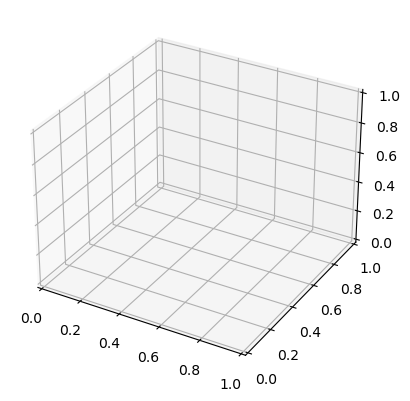

In [215]:
plotframe(data, u_lim, l_lim)